In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
plt.style.use("ggplot")
matplotlib.rcParams.update({'font.size': 24})
PATH_DATA = "../datasets/CYP/"
%load_ext tensorboard

In [2]:
shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
testing_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_testing_2c9 = (testing_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
testing_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_testing_3a4 = (testing_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

features_shared = np.load(os.path.join("features", "shared_set_features.npy"))
features_only_2c9 = np.load(os.path.join("features", "only_2c9_set_features.npy"))
features_only_3a4 = np.load(os.path.join("features", "only_3a4_set_features.npy"))

features_shared_MACCS = np.load(os.path.join("features", "shared_set_features_MACCS.npy"))
features_only_2c9_MACCS = np.load(os.path.join("features", "only_2c9_set_features_MACCS.npy"))
features_only_3a4_MACCS = np.load(os.path.join("features", "only_3a4_set_features_MACCS.npy"))

features_shared_RDKIT = np.load(os.path.join("features", "shared_set_features_RDKIT.npy"))
features_only_2c9_RDKIT = np.load(os.path.join("features", "only_2c9_set_features_RDKIT.npy"))
features_only_3a4_RDKIT = np.load(os.path.join("features", "only_3a4_set_features_RDKIT.npy"))

all_features = [features_shared, features_shared_RDKIT, features_shared_MACCS]
all_features_only_2c9 = [features_only_2c9, features_only_2c9_RDKIT, features_only_2c9_MACCS]

In [3]:
np.hstack(all_features[:3]).shape

(9420, 3239)

In [4]:
def print_metrics(predicted_values, target_values):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly classified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return [accuracy, mcc]

def plot_evolution(val, test):
    fig, axes = plt.subplots(1, 1, figsize=(18, 8))
    lines = axes.plot(val, "x-")
    lines += axes.plot(test, "o-")
    axes.legend(lines, ["Acc. val", "MCC val", "Acc. test", "MCC test"], fontsize=16)
    axes.set_xticks([0, 1, 2])
    axes.set_xticklabels(["Morgan", "Morgan+RDKIT", "Morgan+RDKIT+MACCS"], rotation=90, fontsize=16);
    axes.grid()
    
def test_sizes_set_SVM(labels, features_list, features_only_list, labels_testing):   
    # columns are: accuracy, MCC
    results_test = []
    results_validation = []
    for i in range(1, len(features_list)+1):
        features = np.hstack(features_list[:i])
        features_only = np.hstack(features_only_list[:i])
        model = SVC(C=20, kernel="rbf")
        train_data, val_data, train_labels, val_labels = train_test_split(features, labels, stratify=labels)
        print("Proportion actives in validation:", np.sum(val_labels)/len(val_labels), "Proportion actives in train:", np.sum(train_labels)/len(train_labels))
        history = model.fit(train_data, train_labels)
        predictions = model.predict(val_data)
        print(f"Metrics with {i} features sets with {features.shape[1]} features, validation set, random ligands")
        res_val = print_metrics(predictions, val_labels);
        results_validation.append(res_val)
        print(f"Metrics with {i} features sets with {features_only.shape[1]} features, testing set, random ligands")
        predictions = model.predict(features_only)
        res_test = print_metrics(predictions, labels_testing);
        results_test.append(res_test)  
    return results_test, results_validation

In [5]:
res_test, res_val = test_sizes_set_SVM(labels_2c9, all_features, all_features_only_2c9, labels_testing_2c9)

Proportion actives in validation: 0.3214437367303609 Proportion actives in train: 0.321585279547063
Metrics with 1 features sets with 1024 features, validation set, random ligands
NER: 0.788, Sensitivity or recall: 0.687, Specificity: 0.890, Precision: 0.747, Correctly classified: 0.825, MCC: 0.590
Metrics with 1 features sets with 1024 features, testing set, random ligands
NER: 0.727, Sensitivity or recall: 0.608, Specificity: 0.845, Precision: 0.689, Correctly classified: 0.759, MCC: 0.467
Proportion actives in validation: 0.3214437367303609 Proportion actives in train: 0.321585279547063
Metrics with 2 features sets with 3072 features, validation set, random ligands
NER: 0.801, Sensitivity or recall: 0.707, Specificity: 0.895, Precision: 0.762, Correctly classified: 0.835, MCC: 0.615
Metrics with 2 features sets with 3072 features, testing set, random ligands
NER: 0.737, Sensitivity or recall: 0.633, Specificity: 0.840, Precision: 0.691, Correctly classified: 0.765, MCC: 0.483
Propor

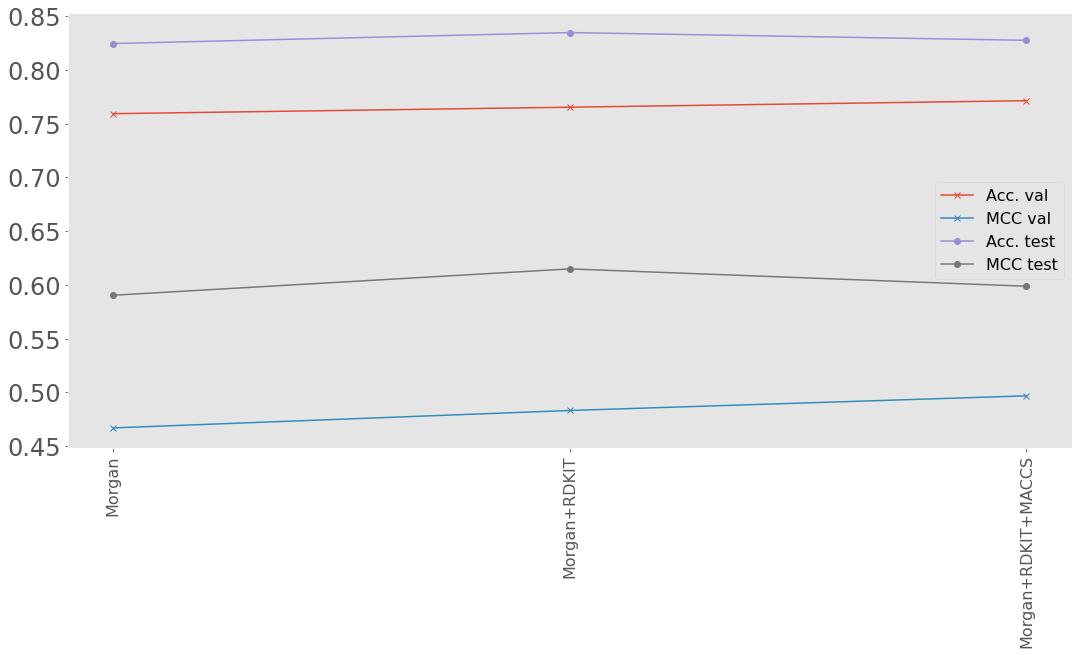

In [6]:
plot_evolution(res_test, res_val)

In [7]:
combined_features = np.hstack(all_features)
combined_features_only_2c9 = np.hstack(all_features_only_2c9)

In [8]:
percentiles = list(range(5,101,5))
n_features = []
results_validation = []
results_test = []
train_data, val_data, train_labels, val_labels = train_test_split(combined_features, labels_2c9, stratify=labels_2c9, random_state=42)
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    feat_select.fit(combined_features, labels_2c9)
    train_data_trans = feat_select.transform(train_data)
    val_data_trans = feat_select.transform(val_data)
    only_2c9_reduced = feat_select.transform(combined_features_only_2c9)
    n_features.append(train_data_trans.shape[1])
    print(f"Validation set with {percentile} percentile, {train_data_trans.shape[1]} features")
    model = SVC(C=20, kernel="rbf")
    history = model.fit(train_data_trans, train_labels)
    predictions = model.predict(val_data_trans)
    results_validation.append(print_metrics(predictions, val_labels))
    predictions = model.predict(only_2c9_reduced)
    results_test.append(print_metrics(predictions, labels_testing_2c9))  


Validation set with 5 percentile, 162 features
NER: 0.763, Sensitivity or recall: 0.666, Specificity: 0.860, Precision: 0.692, Correctly classified: 0.797, MCC: 0.531
NER: 0.704, Sensitivity or recall: 0.584, Specificity: 0.824, Precision: 0.652, Correctly classified: 0.737, MCC: 0.418
Validation set with 10 percentile, 324 features
NER: 0.772, Sensitivity or recall: 0.687, Specificity: 0.857, Precision: 0.695, Correctly classified: 0.803, MCC: 0.546
NER: 0.720, Sensitivity or recall: 0.616, Specificity: 0.823, Precision: 0.663, Correctly classified: 0.748, MCC: 0.447
Validation set with 15 percentile, 486 features
NER: 0.778, Sensitivity or recall: 0.694, Specificity: 0.863, Precision: 0.706, Correctly classified: 0.808, MCC: 0.559
NER: 0.724, Sensitivity or recall: 0.619, Specificity: 0.830, Precision: 0.673, Correctly classified: 0.754, MCC: 0.458
Validation set with 20 percentile, 648 features
NER: 0.779, Sensitivity or recall: 0.691, Specificity: 0.867, Precision: 0.712, Correctly

Text(0.5, 0, 'Number features kept')

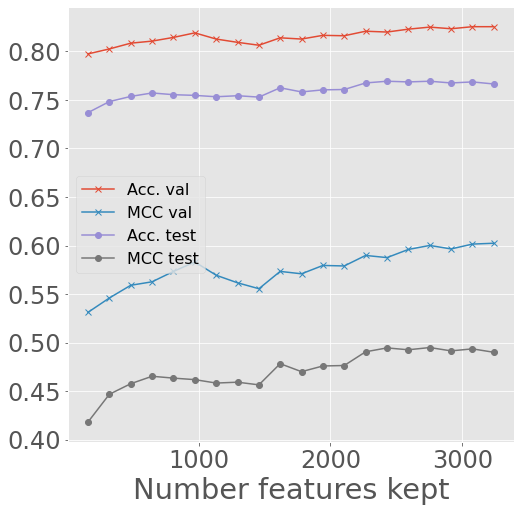

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
lines = axes.plot(n_features, results_validation, "x-")
lines += axes.plot(n_features, results_test, "o-")
axes.legend(lines, ["Acc. val", "MCC val", "Acc. test", "MCC test"], fontsize=16)
axes.set_xlabel("Number features kept")

In [10]:
def generate_model(hidden_layers, neurons, dropout, optimizer, L2, n_bits):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(n_bits, activation='relu', input_shape=(n_bits,)),tf.keras.layers.Dropout(dropout)]+
        [tf.keras.layers.Dense(neurons, kernel_regularizer=tf.keras.regularizers.l2(L2),  activation="relu") for _ in range(hidden_layers)]+
        [tf.keras.layers.Dense(1, activation="sigmoid")])
    loss_function = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
    return model

def test_sizes_set_NN(hidden_layers, neurons, dropout, optimizer, L2, labels, features_list, features_only_list, labels_testing):   
    # columns are: accuracy, MCC
    results_test = []
    results_validation = []
    for i in range(1, len(features_list)+1):
        features = np.hstack(features_list[:i])
        n_bits = features.shape[1]
        model = generate_model(hidden_layers, neurons, dropout, optimizer, L2, n_bits)
        features_only = np.hstack(features_only_list[:i])
        train_data, val_data, train_labels, val_labels = train_test_split(features, labels, stratify=labels)
        print("Proportion actives in validation:", np.sum(val_labels)/len(val_labels), "Proportion actives in train:", np.sum(train_labels)/len(train_labels))
        history = model.fit(train_data, train_labels)
        predictions = model.predict(val_data)
        print(f"Metrics with {i} features sets with {features.shape[1]} features, validation set, random ligands")
        res_val = print_metrics(predictions, val_labels);
        results_validation.append(res_val)
        print(f"Metrics with {i} features sets with {features_only.shape[1]} features, testing set, random ligands")
        predictions = model.predict(features_only)
        res_test = print_metrics(predictions, labels_testing);
        results_test.append(res_test)  
    return results_test, results_validation

In [11]:
hidden_layers = 4
neurons = 160
dropout = 0.5
lr = 0.1
# opt  = tf.keras.optimizers.Adam(lr=lr)
opt = tf.keras.optimizers.SGD(lr=lr)
L2 = 0.01
res_test, res_val = test_sizes_set_NN(hidden_layers, neurons, dropout, opt, L2, labels_2c9, all_features, all_features_only_2c9, labels_testing_2c9)

Proportion actives in validation: 0.3214437367303609 Proportion actives in train: 0.321585279547063
221/221 [==============================] - 5s 21ms/step - loss: 5.6544 - binary_accuracy: 0.6791
Metrics with 1 features sets with 1024 features, validation set, random ligands
NER: 0.577, Sensitivity or recall: 0.174, Specificity: 0.979, Precision: 0.800, Correctly classified: 0.721, MCC: 0.281
Metrics with 1 features sets with 1024 features, testing set, random ligands
NER: 0.530, Sensitivity or recall: 0.080, Specificity: 0.981, Precision: 0.698, Correctly classified: 0.655, MCC: 0.146
Proportion actives in validation: 0.3214437367303609 Proportion actives in train: 0.321585279547063
221/221 [==============================] - 14s 65ms/step - loss: 5.7771 - binary_accuracy: 0.7141
Metrics with 2 features sets with 3072 features, validation set, random ligands
NER: 0.767, Sensitivity or recall: 0.771, Specificity: 0.762, Precision: 0.606, Correctly classified: 0.765, MCC: 0.507
Metrics 

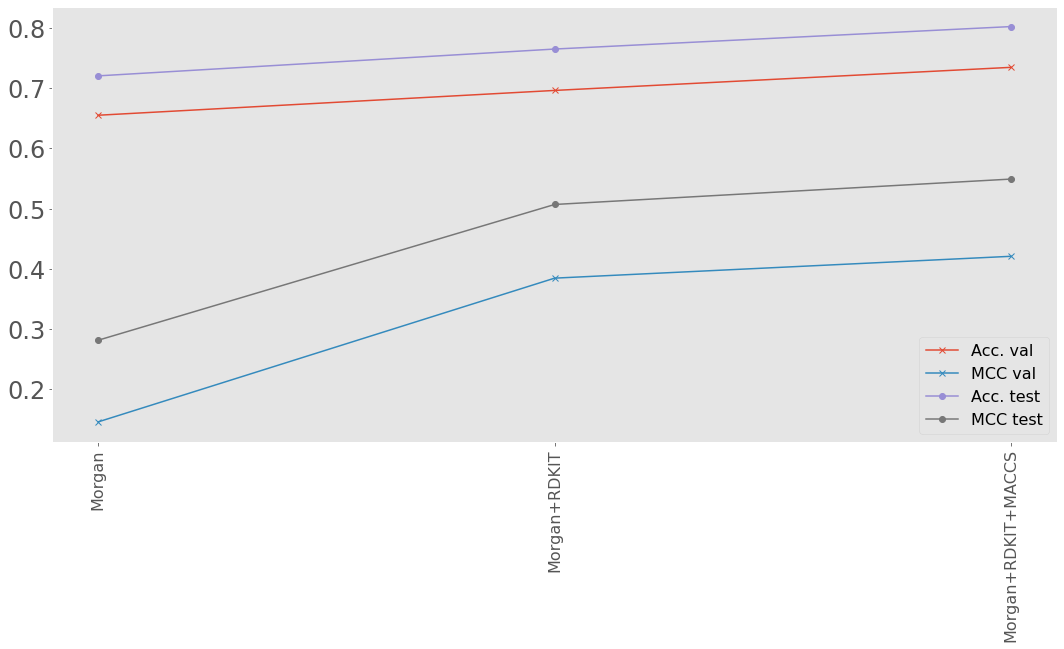

In [12]:
plot_evolution(res_test, res_val)

In [14]:
percentiles = list(range(5,101,5))
n_features = []
results_validation = []
results_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    feat_select.fit(combined_features, labels_2c9)
    train_data_trans = feat_select.transform(train_data)
    val_data_trans = feat_select.transform(val_data)
    only_2c9_reduced = feat_select.transform(combined_features_only_2c9)
    n_features.append(train_data_trans.shape[1])
    n_bits = train_data_trans.shape[1]
    model = generate_model(hidden_layers, neurons, dropout, opt, L2, n_bits)
    history = model.fit(train_data_trans, train_labels)
    predictions = model.predict(val_data_trans)
    print(f"Validation set with {percentile} percentile, {n_bits} features")
    results_validation.append(print_metrics(predictions, val_labels))
    predictions = model.predict(only_2c9_reduced)
    results_test.append(print_metrics(predictions, labels_testing_2c9))  


221/221 [==============================] - 2s 8ms/step - loss: 4.8794 - binary_accuracy: 0.6998
Validation set with 5 percentile, 162 features
NER: 0.704, Sensitivity or recall: 0.563, Specificity: 0.845, Precision: 0.632, Correctly classified: 0.754, MCC: 0.421
NER: 0.639, Sensitivity or recall: 0.476, Specificity: 0.801, Precision: 0.576, Correctly classified: 0.684, MCC: 0.291
221/221 [==============================] - 2s 8ms/step - loss: 5.2108 - binary_accuracy: 0.7015
Validation set with 10 percentile, 324 features
NER: 0.590, Sensitivity or recall: 0.222, Specificity: 0.959, Precision: 0.718, Correctly classified: 0.722, MCC: 0.282
NER: 0.549, Sensitivity or recall: 0.142, Specificity: 0.957, Precision: 0.652, Correctly classified: 0.663, MCC: 0.177
221/221 [==============================] - 3s 11ms/step - loss: 5.3686 - binary_accuracy: 0.7124
Validation set with 15 percentile, 486 features
NER: 0.713, Sensitivity or recall: 0.565, Specificity: 0.860, Precision: 0.657, Correctl

Text(0.5, 0, 'Number features kept')

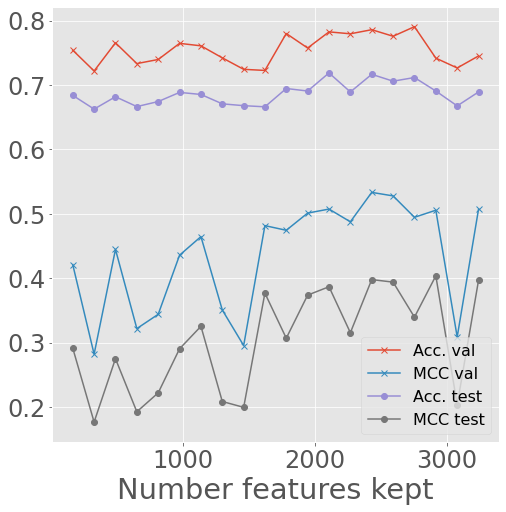

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
lines = axes.plot(n_features, results_validation, "x-")
lines += axes.plot(n_features, results_test, "o-")
axes.legend(lines, ["Acc. val", "MCC val", "Acc. test", "MCC test"], fontsize=16)
axes.set_xlabel("Number features kept")